https://www.kaggle.com/c/choose-tutors/

Ваша задача этом соревновании - предсказать вероятность того, подойдет ли репетитор для подготовки к экзамену по математике.

Вам будут даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

МЕТРИКА - ROC-AUC

Допустимый импорт:
* import numpy as np
* import pandas as pd
* from sklearn.model_selection import train_test_split
* import matplotlib.pyplot as plt
* import seaborn as sns

## IMPORTS

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from my_metrics import roc_auc
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import mode
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

## FUNCTIONS

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame(
        {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
        'importance', ascending=False)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))

    sns.barplot(feature_importances['importance'],
                feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## My class RFClassifier

In [4]:
class RFClassifier:

    def __init__(self, max_features=None,
                 n_trees=2,
                 min_leaf=1,
                 max_depth=np.inf,
                 inf_value_type="Gini",
                 oob_vote:float=None,
                 random_state=None):
        
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.inf_value_type = inf_value_type
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.oob_vote = oob_vote

        self.prediction = None
        self.y_proba = None
        self.proba_data = None
        self.X = None
        self.y = None
        self.forest_pred = []
        self.forest_proba = []
        self.forest_list_to_predict = []
        self.oob_idx = []
        self.oob_scores_list = []

    @staticmethod
    def get_label_num(y_list):
        num = Counter(y_list)
        return dict(num)

    def get_bootstrap_idx(self, n_samples, rdm):
        rng = np.random.RandomState(rdm)
        indexes = rng.randint(0, n_samples-1, size=n_samples)
        return indexes

    def get_subsample(self, n_features, rdm):
        rng = np.random.RandomState(rdm)
        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))
        subsample = rng.choice(
            n_features, self.max_features, replace=False)

        return subsample

    def get_informative_value(self, y_list):
        labels_dict = self.get_label_num(y_list)

        if self.inf_value_type == "Gini":
            impurity = 1
            for label in labels_dict:
                p_label = labels_dict[label] / len(y_list)
                impurity -= p_label**2
            return impurity

        if self.inf_value_type == "Shannon":
            entropy = 0
            for label in labels_dict:
                p_label = labels_dict[label] / len(y_list)
                entropy -= p_label * (0 if (p_label == 0)
                                      else np.log2(p_label))
            return entropy

    def merit_functional(self, true_labels, false_labels, current_informative_value):

        p = (true_labels.shape[0]) / \
            ((true_labels.shape[0]) + (false_labels.shape[0]))
        quality = current_informative_value - p * \
            self.get_informative_value(true_labels) - (1 - p) * \
            self.get_informative_value(false_labels)
        return quality

    def find_best_split(self, X, y, subsample):

        current_informative_value = self.get_informative_value(y)
        best_quality = 0
        best_t = None
        best_index = None
        n_features = X.shape[1]

        for index in subsample:
            t_values = set(X.iloc[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.data_split(
                    X, y, index, t)
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.merit_functional(
                    true_labels, false_labels, current_informative_value)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def data_split(self, X, y, feature_idx, t):

        left = (X.iloc[:, feature_idx] <= t)

        true_data = X[left]
        false_data = X[~left]
        true_labels = y[left]
        false_labels = y[~left]
        return true_data, false_data, true_labels, false_labels

    def tree_fit(self, X, y, subsample):
        leaf_list = []
        prediction_mask = {}
        node_dict = {}
        level = 0
        data_id = 0
        data_list = []
        data_list.append([X, y, None, None, data_id])
        tree_params = []
        next_level_data = []
        fl = 0
        mask = []

        while not fl:
            if level > 0:
                data_list.clear()
                data_list = next_level_data.copy()
                next_level_data.clear()

            for data in data_list:

                best_quality, best_t, best_index = self.find_best_split(
                    data[0], data[1], subsample)
                if best_quality and (level <= self.max_depth):
                    true_data, false_data, true_labels, false_labels = self.data_split(
                        data[0], data[1], best_index, best_t)
                    node_dict[data[4]] = [
                        data[2], data[3], best_index, best_t]
                    data_id += 1
                    next_level_data.append(
                        [true_data, true_labels, True, data[4], data_id])
                    data_id += 1
                    next_level_data.append(
                        [false_data, false_labels, False, data[4], data_id])
                else:
                    leaf = self.get_label_num(data[1])
                    prediction = max(leaf, key=leaf.get)
                    proba = leaf[prediction] / len(data[0])
                    if prediction == 0:
                        proba = 1 - proba
                    leaf_list.append(
                        [data[2], data[3], proba, prediction])

                level += 1

            if (next_level_data == []):
                fl = 1

        for leaf in leaf_list:
            mask = [(leaf[0], leaf[1])]
            next_step = leaf[1]

            while True:

                if next_step is not None and next_step != 0:
                    mask.append(
                        (node_dict[next_step][0], node_dict[next_step][1]))
                    next_step = node_dict[next_step][1]
                else:
                    mask.reverse()
                    prediction_mask[tuple(mask)] = leaf[2], leaf[3]
                    break
        self.forest_list_to_predict.append([prediction_mask, node_dict])

    def fit(self, X, y):
        
        self.X = X
        self.y = y
        
        n_samples = self.X.shape[0]
        n_features = self.X.shape[1]

        if self.random_state:
            rng = np.random.RandomState(self.random_state)
            rdm = rng.randint(1, 1000, self.n_trees)
        

        for tree in range(self.n_trees):
            
            r_state = rdm[tree] if self.random_state else self.random_state
            idx = self.get_bootstrap_idx(n_samples, r_state)
            self.oob_idx.append(list(set(range(n_samples)).difference(idx)))
            subsample = self.get_subsample(n_features, r_state)
            self.tree_fit(self.X.iloc[idx], self.y[idx], subsample)
    
    def predict(self, X_test, oob_score=True, oob_vote:float=None):
        
        forest_proba = []
        forest_pred = []
        y_pred_oob = []
                
        
        for n, tree in enumerate(self.forest_list_to_predict):
            
            
            if self.oob_vote: # oob
                X_oob = self.X.iloc[self.oob_idx[n], :]
                y_pred_proba_list = [None for i in range(len(X_oob))]
                y_pred_oob = [None for i in range(len(X_oob))]
                for mask in tree[0]:

                    answer_mask = []
                    predict_mask = [mask[i][0] for i in range(len(mask))]

                    for question in mask:

                        idx = tree[1][question[1]][2]
                        t = tree[1][question[1]][3]
                        y_pred_proba = [tree[0][mask]]
                        answer_mask.append(X_oob.iloc[:, idx] <= t)
                        answer_mask_array = np.array(answer_mask).T.tolist()


                    for num, answer in enumerate(answer_mask_array):
                        if answer == predict_mask and y_pred_proba_list[num] is None:
                            y_pred_oob[num] = y_pred_proba
                oob_prediction = np.array(y_pred_oob).reshape(-1, 2)[:, 1]
                self.oob_scores_list.append(metrics(self.y[self.oob_idx[n]], oob_prediction, metric='accuracy'))

            y_pred_proba_list = [None for i in range(len(X_test))]    
                        
            for mask in tree[0]:

                answer_mask = []
                predict_mask = [mask[i][0] for i in range(len(mask))]

                for question in mask:

                    idx = tree[1][question[1]][2]
                    t = tree[1][question[1]][3]
                    y_pred_proba = [tree[0][mask]]
                    answer_mask.append(X_test.iloc[:, idx] <= t)
                    answer_mask_array = np.array(answer_mask).T.tolist()
                    
                    
                for num, answer in enumerate(answer_mask_array):
                    if answer == predict_mask and y_pred_proba_list[num] is None:
                        y_pred_proba_list[num] = y_pred_proba
                    


            prediction = np.array(y_pred_proba_list).reshape(-1, 2)[:, 1]
            y_proba = np.array(y_pred_proba_list).reshape(-1, 2)[:, 0]
            forest_proba.append(y_proba)
            forest_pred.append(prediction)
                
        self.forest_pred = np.array(forest_pred).T.reshape(X_test.shape[0], -1)
        self.forest_proba = np.array(forest_proba).T.reshape(X_test.shape[0], -1)
        if self.oob_vote:
            vote_mask = (self.oob_scores_list >= np.quantile(self.oob_scores_list, self.oob_vote))
            self.forest_proba = np.delete(self.forest_proba, vote_mask, axis=1)
            self.forest_pred = np.delete(self.forest_pred, vote_mask, axis=1)
        
        return mode(self.forest_pred, axis=1)[0].flatten(), np.mean(self.forest_proba, axis=1)

## LOAD DATA

In [5]:
df_train = reduce_mem_usage(pd.read_csv('data/train.csv'))
df_test = reduce_mem_usage(pd.read_csv('data/test.csv'))
df_train.describe()

Memory usage of dataframe is 0.99 MB
Memory usage after optimization is: 0.45 MB
Decreased by 54.8%
Memory usage of dataframe is 0.92 MB
Memory usage after optimization is: 0.44 MB
Decreased by 52.1%


,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,4999.50,45.80,1.97,1702.44,1.72,0.37,0.12,0.12,0.06,0.03,0.02,64.44,0.11
std,2886.90,8.03,1.77,523.78,0.80,0.48,0.33,0.32,0.24,0.16,0.13,13.59,0.31
min,0.00,23.00,0.00,200.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,33.00,0.00
25%,2499.75,40.00,0.00,1300.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,55.00,0.00
50%,4999.50,46.00,2.00,1550.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,63.00,0.00
75%,7499.25,51.00,3.00,2150.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,74.00,0.00
max,9999.00,68.00,9.00,3950.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,100.00,1.00


## Feature engineering
**Данные не содержат выбросов**

In [6]:
class Features:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.df['age_price'] = self.df['lesson_price'] / self.df['age']
        self.df['exp_age'] = self.df['years_of_experience'] / self.df['age']
        self.df['exp_price'] = self.df['years_of_experience'] / \
            self.df['lesson_price']
        self.df['qua_price'] = self.df['qualification'] / \
            self.df['lesson_price']
        self.df['qua_age'] = self.df['qualification'] / self.df['age']
        self.df['exp_qua'] = self.df['years_of_experience'] * \
            self.df['qualification']
        self.df['exam_qua'] = self.df['mean_exam_points'] / \
            self.df['qualification']
        self.df['exam_age'] = self.df['mean_exam_points'] / self.df['age']
        self.df['exam_price'] = self.df['mean_exam_points'] / \
            self.df['lesson_price']
        self.df['ph_ch_b'] = self.df['physics'] + \
            self.df['chemistry'] + self.df['biology']
        self.df['en_geo_hist'] = self.df['english'] + \
            self.df['geography'] + self.df['history']
        self.df['all_sub'] = self.df['physics'] + self.df['chemistry'] + \
            self.df['biology'] + self.df['english'] + \
            self.df['geography'] + self.df['history']
        
        return self.df

In [7]:
feat = Features(df_train)
df_train = feat.transform()
df_train.describe()
feat = Features(df_test)
df_test = feat.transform()

In [8]:
df_train.set_index(keys='Id', inplace=True)
df_train.choose.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

## Model and features selection¶

In [9]:
features = ['physics',
            'exam_price',
            'ph_ch_b',
            'qua_price',
            'all_sub',
            'qualification',
            'mean_exam_points',
            'exp_qua',
            'lesson_price',
            'exam_age',
            'age',
            'qua_age',
            'biology',
            'age_price',
            'exam_qua',
            'years_of_experience']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features].reset_index(drop=True), df_train['choose'],
                                                    shuffle=True,
                                                    test_size=0.25,
                                                    random_state=13,
                                                    stratify=df_train['choose'])

In [23]:
model = RFClassifier(
    random_state=13,
    max_depth=7,
    min_leaf=1,
    n_trees=180,
    inf_value_type="Shannon",
    oob_vote=0.75
)
model.fit(X_train.reset_index(drop=True), y_train.reset_index(drop=True))

In [24]:
y_pred, y_proba =  model.predict(X_test)

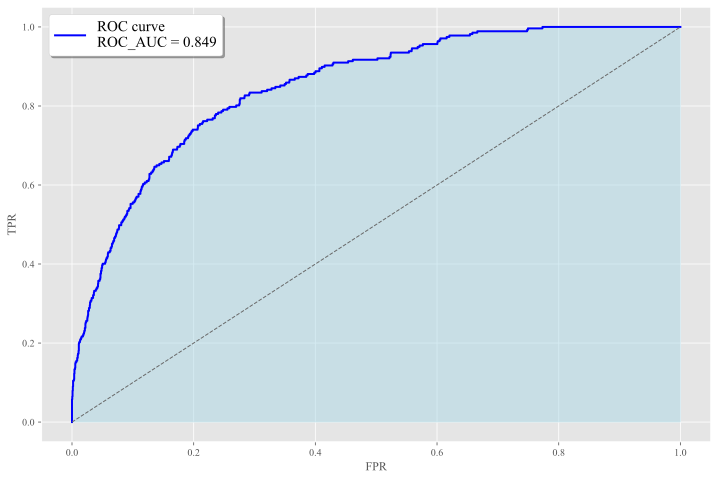

In [25]:
roc_auc(y_test, y_proba)

## Predictions

In [14]:
model.fit(df_train[features].reset_index(drop=True), df_train['choose'].reset_index(drop=True))

In [28]:
_, y_proba =  model.predict(df_test[features])

In [29]:
df_test['preds'] = y_proba
df_to_send = df_test[['Id', 'preds']]
savename = "rf_pred.csv"
df_to_send.to_csv(savename, index=False, encoding='utf-8')